In [ ]:
# Update environment (if needed)
# !sudo apt update

# Download and install Java
!sudo apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install Apache Spark with Hadoop
!wget -nc -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

# Unzip the folder
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Install findspark library that will locate Spark on the system
!pip install -q findspark

In [ ]:
# Setting the environment variables, to enable running PySpark in Colab environment.

import os
import shutil
from itertools import islice
import requests

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
# Locate Spark in the system

import findspark
findspark.init()

#### Import SparkSession and SparkSQL

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

spark.version

'3.5.0'

#### Mount Google drive, we will be using GDrive for processing
Files will be present in "/content/drive/My Drive".

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Set-up helper functions

In [ ]:
import os
import shutil
from itertools import islice
import requests
import pandas as pd

pd.set_option("max_colwidth", 100)

In [ ]:
def list_files(dir_name):
    try:
        list_of_files = [file_name for file_name in os.listdir(dir_name) if os.path.isfile(os.path.join(dir_name, file_name))]
        files_with_size = [ (file_name, os.stat(os.path.join(dir_name, file_name)).st_size)
                    for file_name in list_of_files if not file_name.startswith('.')]
        for file_name, size in files_with_size:
            print(file_name, ' -->', size)
    except OSError as e:
        print("Error: %s : %s" % (dir_name, e.strerror))

In [ ]:
def delete_folder(dir_name):
    try:
        shutil.rmtree(dir_name)
    except OSError as e:
        print("Error: %s : %s" % (dir_name, e.strerror))

#### Pull source data from GCS into Colab

In [ ]:
def get_gcs_data (bucket_name, folder_name, file_name, path_gdrive):
    url = 'https://storage.googleapis.com/' + bucket_name + '/' + folder_name + '/' + file_name
    r = requests.get(url)
    open(path_gdrive + '/' + file_name , 'wb').write(r.content)

BDP Assignment 6

In [ ]:
#Copy files from GCS bucket into my Google Drive:
#https://storage.googleapis.com/msca-bdp-data-open/airlines/2007.csvLinks to an external site.
#https://storage.googleapis.com/msca-bdp-data-open/airlines/2008.csvLinks to an external site.

bucket_name = 'msca-bdp-data-open'
folder_name = 'airlines'
file_name = ['2007.csv', '2008.csv']
path_gdrive = '/content/drive/My Drive/Colab Notebooks/airlines/'

os.makedirs(path_gdrive, exist_ok=True)

for file in file_name:
    get_gcs_data (bucket_name = bucket_name,
                 folder_name = folder_name,
                 file_name = file,
                 path_gdrive = path_gdrive)
    print('Downloaded: ' + file)

Downloaded: 2007.csv
Downloaded: 2008.csv


In [ ]:
#1. Which locations (Origin and Dest pairs) had the worst delays for both arrivals (ArrDelay) and departures (DepDelay) - for each year

!head '/content/drive/My Drive/Colab Notebooks/airlines/2007.csv'
!head '/content/drive/My Drive/Colab Notebooks/airlines/2008.csv'

Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2007,1,1,1,1232,1225,1341,1340,WN,2891,N351,69,75,54,1,7,SMF,ONT,389,4,11,0,,0,0,0,0,0,0
2007,1,1,1,1918,1905,2043,2035,WN,462,N370,85,90,74,8,13,SMF,PDX,479,5,6,0,,0,0,0,0,0,0
2007,1,1,1,2206,2130,2334,2300,WN,1229,N685,88,90,73,34,36,SMF,PDX,479,6,9,0,,0,3,0,0,0,31
2007,1,1,1,1230,1200,1356,1330,WN,1355,N364,86,90,75,26,30,SMF,PDX,479,3,8,0,,0,23,0,0,0,3
2007,1,1,1,831,830,957,1000,WN,2278,N480,86,90,74,-3,1,SMF,PDX,479,3,9,0,,0,0,0,0,0,0
2007,1,1,1,1430,1420,1553,1550,WN,2386,N611SW,83,90,74,3,10,SMF,PDX,479,2,7,0,,0,0,0,0,0,0
2007,1,1,1,1936,1840,2217,2130,WN,409,N482,101,110,89,47,56,SMF,PHX,647,5,7,0,,0,46,0,0,0,1
2007,1,1,1,944,935,1223,1225,WN,1131,N749SW,99,110,86,-2,9,SMF,PHX,647,4

In [ ]:
#Read Insurance.csv into Spark Dataframe
path = path_gdrive+'/2007.csv'

twoseven_df = spark.read.csv(path, header='true', inferSchema='true', sep=',', quote='"')


columns_to_replace = ["ArrDelay", "DepDelay"]
# Replace null values with 0 in specified columns
for column in columns_to_replace:
    twoseven_df = twoseven_df.withColumn(column, when(col(column).isNotNull(), col(column)).otherwise(0))


In [ ]:
row_count = twoseven_df.count()
row_count

7453215

In [ ]:
twoseven_df.show(10)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2007|    1|         1|        1|   1232|      1225|   1341|      1340|           WN|     2891

In [ ]:
twoseven_df_agg = twoseven_df.groupby('Origin', 'Dest').\
agg(
    sum('ArrDelay').alias('ArrDelay_sum'),\
    sum('DepDelay').alias('DepDelay_sum'))

In [ ]:
columns_to_replace = ["ArrDelay_sum", "DepDelay_sum"]
# Replace null values with 0 in specified columns
for column in columns_to_replace:
    twoseven_df_agg = twoseven_df_agg.withColumn(column, when(col(column).isNotNull(), col(column)).otherwise(0))

twoseven_df_agg.show()

+------+----+------------+------------+
|Origin|Dest|ArrDelay_sum|DepDelay_sum|
+------+----+------------+------------+
|   SNA| PHX|     43812.0|     50765.0|
|   LAS| LIT|       864.0|      2894.0|
|   PHL| MCO|     98374.0|    123996.0|
|   SMF| BUR|     19590.0|     32618.0|
|   MCI| IAH|     16495.0|     15138.0|
|   ROC| CLE|     21199.0|     16140.0|
|   ATL| GSP|     20327.0|     26620.0|
|   LAX| OXR|      4259.0|      3417.0|
|   SPI| ORD|     27772.0|     27513.0|
|   ORD| PDX|     57629.0|     58505.0|
|   PBI| DCA|     11962.0|      8337.0|
|   FSD| ATL|      1163.0|      5601.0|
|   MLI| MCO|       747.0|       598.0|
|   MSP| AVL|      1624.0|      2207.0|
|   ADK| AKN|      1065.0|      1445.0|
|   BQN| MCO|      2773.0|      5231.0|
|   EWR| STT|      -212.0|       760.0|
|   CLE| SJU|       103.0|       262.0|
|   AVP| JFK|       542.0|       377.0|
|   AUS| ELP|      6350.0|     12856.0|
+------+----+------------+------------+
only showing top 20 rows



In [ ]:
twoseven_df_agg_final = twoseven_df_agg.\
withColumn("Total_Delay", col("ArrDelay_sum") + col("DepDelay_sum"))
twoseven_df_agg_final.show()

+------+----+------------+------------+-----------+
|Origin|Dest|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+----+------------+------------+-----------+
|   SNA| PHX|     43812.0|     50765.0|    94577.0|
|   LAS| LIT|       864.0|      2894.0|     3758.0|
|   PHL| MCO|     98374.0|    123996.0|   222370.0|
|   SMF| BUR|     19590.0|     32618.0|    52208.0|
|   MCI| IAH|     16495.0|     15138.0|    31633.0|
|   ROC| CLE|     21199.0|     16140.0|    37339.0|
|   ATL| GSP|     20327.0|     26620.0|    46947.0|
|   LAX| OXR|      4259.0|      3417.0|     7676.0|
|   SPI| ORD|     27772.0|     27513.0|    55285.0|
|   ORD| PDX|     57629.0|     58505.0|   116134.0|
|   PBI| DCA|     11962.0|      8337.0|    20299.0|
|   FSD| ATL|      1163.0|      5601.0|     6764.0|
|   MLI| MCO|       747.0|       598.0|     1345.0|
|   MSP| AVL|      1624.0|      2207.0|     3831.0|
|   ADK| AKN|      1065.0|      1445.0|     2510.0|
|   BQN| MCO|      2773.0|      5231.0|     8004.0|
|   EWR| STT

In [ ]:
#locations (Origin and Dest pairs) with worst delays for both arrivals (ArrDelay) and departures (DepDelay) in 2007

twoseven_df_agg_final.orderBy('Total_Delay', ascending=False).show(1)

+------+----+------------+------------+-----------+
|Origin|Dest|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+----+------------+------------+-----------+
|   ORD| LGA|    250887.0|    232295.0|   483182.0|
+------+----+------------+------------+-----------+
only showing top 1 row



In [ ]:
#Read Insurance.csv into Spark Dataframe
path = path_gdrive+'/2008.csv'

twoeight_df = spark.read.csv(path, header='true', inferSchema='true', sep=',', quote='"')

columns_to_replace = ["ArrDelay", "DepDelay"]

# Replace null values with 0 in specified columns
for column in columns_to_replace:
    twoeight_df = twoeight_df.withColumn(column, when(col(column).isNotNull(), col(column)).otherwise(0))


twoeight_df.show(10)

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|2008|    1|         3|        4|   2003|      1955|   2211|      2225|           WN|      335

In [ ]:
twoeight_df_agg = twoeight_df.groupby('Origin', 'Dest').\
agg(
    sum('ArrDelay').alias('ArrDelay_sum'),\
    sum('DepDelay').alias('DepDelay_sum'))

In [ ]:
columns_to_replace = ["ArrDelay_sum", "DepDelay_sum"]

# Replace null values with 0 in specified columns
for column in columns_to_replace:
    twoeight_df_agg = twoeight_df_agg.withColumn(column, when(col(column).isNotNull(), col(column)).otherwise(0))

twoeight_df_agg.show()

+------+----+------------+------------+
|Origin|Dest|ArrDelay_sum|DepDelay_sum|
+------+----+------------+------------+
|   LAS| LIT|      -597.0|      2846.0|
|   PHL| MCO|     49237.0|     87162.0|
|   SMF| BUR|      7525.0|     23382.0|
|   SNA| PHX|     15245.0|     26525.0|
|   MCI| IAH|     16058.0|     10323.0|
|   BFL| SAN|      -149.0|       243.0|
|   ROC| CLE|     15426.0|     15738.0|
|   SPI| ORD|     21116.0|     21927.0|
|   ATL| GSP|     20174.0|     23773.0|
|   LAX| OXR|      -685.0|      2596.0|
|   SFO| PMD|      5628.0|      6377.0|
|   ORD| PDX|     40921.0|     48355.0|
|   PBI| DCA|       -40.0|      3434.0|
|   FSD| ATL|      2457.0|      1980.0|
|   MLI| MCO|      2447.0|      2828.0|
|   MSP| AVL|         8.0|      1563.0|
|   BQN| MCO|      1246.0|      3200.0|
|   EWR| STT|       148.0|      1439.0|
|   CLE| SJU|        49.0|       110.0|
|   SJC| ONT|      7298.0|     19722.0|
+------+----+------------+------------+
only showing top 20 rows



In [ ]:
twoeight_df_agg_final = twoeight_df_agg.\
withColumn("Total_Delay", col("ArrDelay_sum") + col("DepDelay_sum"))
twoeight_df_agg_final.show()

+------+----+------------+------------+-----------+
|Origin|Dest|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+----+------------+------------+-----------+
|   LAS| LIT|      -597.0|      2846.0|     2249.0|
|   PHL| MCO|     49237.0|     87162.0|   136399.0|
|   SMF| BUR|      7525.0|     23382.0|    30907.0|
|   SNA| PHX|     15245.0|     26525.0|    41770.0|
|   MCI| IAH|     16058.0|     10323.0|    26381.0|
|   BFL| SAN|      -149.0|       243.0|       94.0|
|   ROC| CLE|     15426.0|     15738.0|    31164.0|
|   SPI| ORD|     21116.0|     21927.0|    43043.0|
|   ATL| GSP|     20174.0|     23773.0|    43947.0|
|   LAX| OXR|      -685.0|      2596.0|     1911.0|
|   SFO| PMD|      5628.0|      6377.0|    12005.0|
|   ORD| PDX|     40921.0|     48355.0|    89276.0|
|   PBI| DCA|       -40.0|      3434.0|     3394.0|
|   FSD| ATL|      2457.0|      1980.0|     4437.0|
|   MLI| MCO|      2447.0|      2828.0|     5275.0|
|   MSP| AVL|         8.0|      1563.0|     1571.0|
|   BQN| MCO

In [ ]:
#locations (Origin and Dest pairs) with worst delays for both arrivals (ArrDelay) and departures (DepDelay) in 2008

twoeight_df_agg_final.orderBy('Total_Delay', ascending=False).show(1)

+------+----+------------+------------+-----------+
|Origin|Dest|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+----+------------+------------+-----------+
|   ORD| LGA|    209318.0|    226044.0|   435362.0|
+------+----+------------+------------+-----------+
only showing top 1 row



In [ ]:
#2. Which locations had fewest delays.

In [ ]:
#locations (Origin and Dest pairs) with fewest delays for both arrivals (ArrDelay) and departures (DepDelay) in 2007

twoseven_df_agg_final.orderBy('Total_Delay', ascending=True).show(1)

+------+----+------------+------------+-----------+
|Origin|Dest|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+----+------------+------------+-----------+
|   LIH| HNL|    -21010.0|    -28338.0|   -49348.0|
+------+----+------------+------------+-----------+
only showing top 1 row



In [ ]:
#locations (Origin and Dest pairs) with fewest delays for both arrivals (ArrDelay) and departures (DepDelay) in 2008

twoeight_df_agg_final.orderBy('Total_Delay', ascending=True).show(1)

+------+----+------------+------------+-----------+
|Origin|Dest|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+----+------------+------------+-----------+
|   PIH| SLC|    -10740.0|     -6802.0|   -17542.0|
+------+----+------------+------------+-----------+
only showing top 1 row



In [ ]:
#3. Do you see any significant seasonality effects for delays?

In [ ]:
conditions = [
    (twoseven_df["Month"].isin([12, 1, 2]), "Winter"),
    (twoseven_df["Month"].between(3, 5), "Spring"),
    (twoseven_df["Month"].between(6, 8), "Summer"),
    (twoseven_df["Month"].between(9, 11), "Fall"),
]

twoseven_df_month_cond = twoseven_df.\
withColumn("Season", when(conditions[0][0], conditions[0][1])\
                            .when(conditions[1][0], conditions[1][1])\
                            .when(conditions[2][0], conditions[2][1])\
                            .when(conditions[3][0], conditions[3][1])\
                            .otherwise("Unknown"))

In [ ]:
twoseven_df_month_agg = twoseven_df_month_cond.groupby('Season').\
agg(
    sum('ArrDelay').alias('ArrDelay_sum'),\
    sum('DepDelay').alias('DepDelay_sum'))



In [ ]:
twoseven_df_month_agg.show()

+------+------------+------------+
|Season|ArrDelay_sum|DepDelay_sum|
+------+------------+------------+
|Spring| 1.5779672E7| 1.8652243E7|
|Winter| 2.2409221E7| 2.3407334E7|
|Summer| 2.6827437E7| 2.7987916E7|
|  Fall|   9134719.0| 1.3080372E7|
+------+------------+------------+



In [ ]:
twoseven_df_month_agg_final = twoseven_df_month_agg.\
withColumn("Total_Delay", col("ArrDelay_sum") + col("DepDelay_sum"))
twoseven_df_month_agg_final.show()

+------+------------+------------+-----------+
|Season|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+------------+------------+-----------+
|Spring| 1.5779672E7| 1.8652243E7|3.4431915E7|
|Winter| 2.2409221E7| 2.3407334E7|4.5816555E7|
|Summer| 2.6827437E7| 2.7987916E7|5.4815353E7|
|  Fall|   9134719.0| 1.3080372E7|2.2215091E7|
+------+------------+------------+-----------+



In [ ]:
twoseven_df_month_agg_final.orderBy('Total_Delay', ascending=False).show()

+------+------------+------------+-----------+
|Season|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+------------+------------+-----------+
|Summer| 2.6827437E7| 2.7987916E7|5.4815353E7|
|Winter| 2.2409221E7| 2.3407334E7|4.5816555E7|
|Spring| 1.5779672E7| 1.8652243E7|3.4431915E7|
|  Fall|   9134719.0| 1.3080372E7|2.2215091E7|
+------+------------+------------+-----------+



In [ ]:
#In terms of seasonality in 2007, we do see that it delays the most during the Summer, followed by Winter, then Spring, and Fall having the least amount of delay.

In [ ]:
conditions = [
    (twoeight_df["Month"].isin([12, 1, 2]), "Winter"),
    (twoeight_df["Month"].between(3, 5), "Spring"),
    (twoeight_df["Month"].between(6, 8), "Summer"),
    (twoeight_df["Month"].between(9, 11), "Fall"),
]

twoeight_df_month_cond = twoeight_df.\
withColumn("Season", when(conditions[0][0], conditions[0][1])\
                            .when(conditions[1][0], conditions[1][1])\
                            .when(conditions[2][0], conditions[2][1])\
                            .when(conditions[3][0], conditions[3][1])\
                            .otherwise("Unknown"))

In [ ]:
twoeight_df_month_agg = twoeight_df_month_cond.groupby('Season').\
agg(
    sum('ArrDelay').alias('ArrDelay_sum'),\
    sum('DepDelay').alias('DepDelay_sum'))

In [ ]:
twoeight_df_month_agg.show()

+------+------------+------------+
|Season|ArrDelay_sum|DepDelay_sum|
+------+------------+------------+
|Spring| 1.4273217E7| 1.6900122E7|
|Winter| 2.1887824E7| 2.3408405E7|
|Summer| 1.8190403E7| 2.1216588E7|
|  Fall|   1643534.0|   7021166.0|
+------+------------+------------+



In [ ]:
twoeight_df_month_agg_final = twoeight_df_month_agg.\
withColumn("Total_Delay", col("ArrDelay_sum") + col("DepDelay_sum"))
twoeight_df_month_agg_final.show()

+------+------------+------------+-----------+
|Season|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+------------+------------+-----------+
|Spring| 1.4273217E7| 1.6900122E7|3.1173339E7|
|Winter| 2.1887824E7| 2.3408405E7|4.5296229E7|
|Summer| 1.8190403E7| 2.1216588E7|3.9406991E7|
|  Fall|   1643534.0|   7021166.0|  8664700.0|
+------+------------+------------+-----------+



In [ ]:
twoeight_df_month_agg_final.orderBy('Total_Delay', ascending=False).show()

+------+------------+------------+-----------+
|Season|ArrDelay_sum|DepDelay_sum|Total_Delay|
+------+------------+------------+-----------+
|Winter| 2.1887824E7| 2.3408405E7|4.5296229E7|
|Summer| 1.8190403E7| 2.1216588E7|3.9406991E7|
|Spring| 1.4273217E7| 1.6900122E7|3.1173339E7|
|  Fall|   1643534.0|   7021166.0|  8664700.0|
+------+------------+------------+-----------+



In [ ]:
#In terms of seasonality in 2008, we do see that it delays the most during the Winter, followed by Summer, then Spring, and Fall having the least amount of delay.

In [ ]:
#So to conclude for the whether or not I see any significant seasonality effects for delays, I would say that you would expect to see more delays during Summer and Winter, and least delay in the Fall for any given year.

In [ ]:
#4. Do you see any increase or decrease in delays on weekends?

In [ ]:
conditions = [
    (twoseven_df["DayOfWeek"].isin([6, 7]), "Weekend"),
    (twoseven_df["DayOfWeek"].isin(1,2,3,4,5), "Weekday"),
]

twoseven_df_dow_cond = twoseven_df.\
withColumn("DayType", when(conditions[0][0], conditions[0][1])\
                            .when(conditions[1][0], conditions[1][1])\
                            .otherwise("Unknown"))

In [ ]:
twoseven_df_dow_agg = twoseven_df_dow_cond.groupby('DayType').\
agg(
    avg('ArrDelay').alias('ArrDelay_avg'),\
    avg('DepDelay').alias('DepDelay_avg'))



In [ ]:
twoseven_df_dow_agg.show()

+-------+-----------------+------------------+
|DayType|     ArrDelay_avg|      DepDelay_avg|
+-------+-----------------+------------------+
|Weekday|10.91078862872423|11.700949797840268|
|Weekend| 8.20582644427129|10.564578394992568|
+-------+-----------------+------------------+



In [ ]:
#In 2007, we see slightly less total delays on the Weekends!

In [ ]:
conditions = [
    (twoeight_df["DayOfWeek"].isin([6, 7]), "Weekend"),
    (twoeight_df["DayOfWeek"].isin(1,2,3,4,5), "Weekday"),
]

twoeight_df_dow_cond = twoeight_df.\
withColumn("DayType", when(conditions[0][0], conditions[0][1])\
                            .when(conditions[1][0], conditions[1][1])\
                            .otherwise("Unknown"))

In [ ]:
twoeight_df_dow_agg = twoeight_df_dow_cond.groupby('DayType').\
agg(
    avg('ArrDelay').alias('ArrDelay_avg'),\
    avg('DepDelay').alias('DepDelay_avg'))



In [ ]:
twoeight_df_dow_agg.show()

+-------+-----------------+------------------+
|DayType|     ArrDelay_avg|      DepDelay_avg|
+-------+-----------------+------------------+
|Weekday|8.313381471589537| 9.891560220129755|
|Weekend|7.760762380478254|10.200386795916625|
+-------+-----------------+------------------+



In [ ]:
#In 2008, we see very slightly less total delays on the Weekends!

In [ ]:
# In conclusion, to answer if I see any increase or decrease in delays on weekends, the answer is we will see slightly less total delays on the weekends on average in any given year.

In [ ]:
#5. Are flights equally distributed throughout the day?
#   Plot the distribution of DepTime, ArrTime (actual departure and arrival time)

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [ ]:
twoseven_df_times = twoseven_df.select("DepTime", "ArrTime")
twoseven_df_times.show()

+-------+-------+
|DepTime|ArrTime|
+-------+-------+
|   1232|   1341|
|   1918|   2043|
|   2206|   2334|
|   1230|   1356|
|    831|    957|
|   1430|   1553|
|   1936|   2217|
|    944|   1223|
|   1537|   1819|
|   1318|   1603|
|    836|   1119|
|   2047|   2332|
|   2128|   2245|
|    935|   1048|
|   1251|   1405|
|   1729|   1843|
|    825|    941|
|   1042|   1158|
|   1726|   1839|
|   1849|   2016|
+-------+-------+
only showing top 20 rows



In [ ]:
twoseven_df_deptime = twoseven_df_times.groupby('DepTime').\
agg(
    count('DepTime').alias('DepTime_Frequency'))
twoseven_df_deptime.show()

+-------+-----------------+
|DepTime|DepTime_Frequency|
+-------+-----------------+
|    829|             8719|
|   1159|             7608|
|   1512|             6928|
|   1436|             6515|
|   2136|             3798|
|    944|             6626|
|    800|            11720|
|    853|             8527|
|   2110|             6943|
|    125|              123|
|    451|              133|
|   1746|             6745|
|   1241|             6862|
|   1808|             6504|
|    919|             7059|
|    926|             7827|
|   1953|             6157|
|   2034|             4499|
|   1903|             6678|
|   1528|             7664|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoseven_df_deptime.count()

1440

In [ ]:
p_twoseven_deptime_df = twoseven_df_deptime.limit(2_000).toPandas()

Text(0.5, 1.0, 'Bar Chart of DepTime vs. Frequencies')

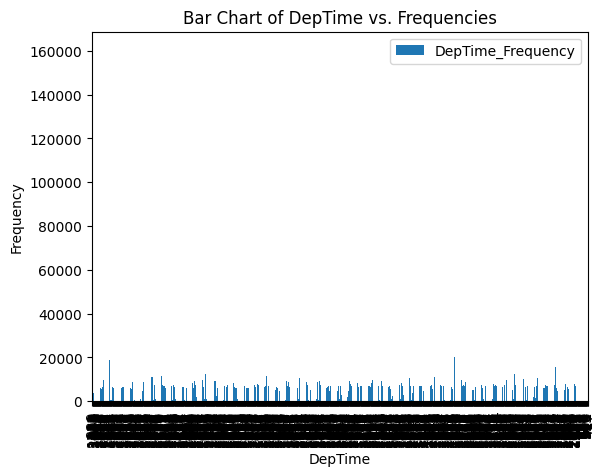

In [ ]:
# Create a bar chart
p_twoseven_deptime_df.plot(x='DepTime', y='DepTime_Frequency', kind='bar')

# Set labels and title
plt.xlabel("DepTime")
plt.ylabel("Frequency")
plt.title("Bar Chart of DepTime vs. Frequencies")

In [ ]:
twoseven_df_deptime.orderBy('DepTime_Frequency', ascending=False).show()

+-------+-----------------+
|DepTime|DepTime_Frequency|
+-------+-----------------+
|     NA|           160748|
|    600|            20066|
|    700|            18749|
|    655|            15848|
|    555|            15564|
|    630|            13554|
|    557|            13327|
|    558|            13180|
|    556|            13014|
|    625|            12672|
|    855|            12640|
|    900|            12634|
|    657|            12492|
|    656|            12346|
|    755|            12158|
|    658|            12119|
|   1100|            11985|
|   1000|            11822|
|    659|            11793|
|    800|            11720|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoseven_df_deptime.orderBy('DepTime_Frequency', ascending=True).show()

+-------+-----------------+
|DepTime|DepTime_Frequency|
+-------+-----------------+
|    343|                1|
|    347|                2|
|    436|                2|
|    424|                3|
|    422|                3|
|    333|                3|
|    434|                3|
|    338|                4|
|    348|                4|
|    335|                4|
|    429|                5|
|    337|                5|
|    435|                5|
|    432|                5|
|    423|                5|
|    336|                5|
|    346|                5|
|    421|                5|
|    417|                5|
|    327|                6|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoeight_df_times = twoeight_df.select("DepTime", "ArrTime")
twoeight_df_times.show()

+-------+-------+
|DepTime|ArrTime|
+-------+-------+
|   2003|   2211|
|    754|   1002|
|    628|    804|
|    926|   1054|
|   1829|   1959|
|   1940|   2121|
|   1937|   2037|
|   1039|   1132|
|    617|    652|
|   1620|   1639|
|    706|    916|
|   1644|   1845|
|   1426|   1426|
|    715|    720|
|   1702|   1651|
|   1029|   1021|
|   1452|   1640|
|    754|    940|
|   1323|   1526|
|   1416|   1512|
+-------+-------+
only showing top 20 rows



In [ ]:
twoeight_df_deptime = twoeight_df_times.groupby('DepTime').\
agg(
    count('DepTime').alias('DepTime_Frequency'))
twoeight_df_deptime.show()

+-------+-----------------+
|DepTime|DepTime_Frequency|
+-------+-----------------+
|   1512|             6652|
|   1159|             7269|
|    829|             8561|
|   2136|             3972|
|   1436|             6894|
|    944|             6381|
|    853|             7794|
|   2110|             5924|
|    800|            10125|
|    125|              110|
|    451|              132|
|    926|             7202|
|    919|             6347|
|   1808|             5921|
|   1241|             6266|
|   1746|             6343|
|   1528|             7356|
|   1903|             6438|
|   1953|             6047|
|   2034|             4046|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoeight_df_deptime.count()

1441

In [ ]:
p_twoeight_deptime_df = twoeight_df_deptime.limit(2_000).toPandas()

Text(0.5, 1.0, 'Bar Chart of DepTime vs. Frequencies')

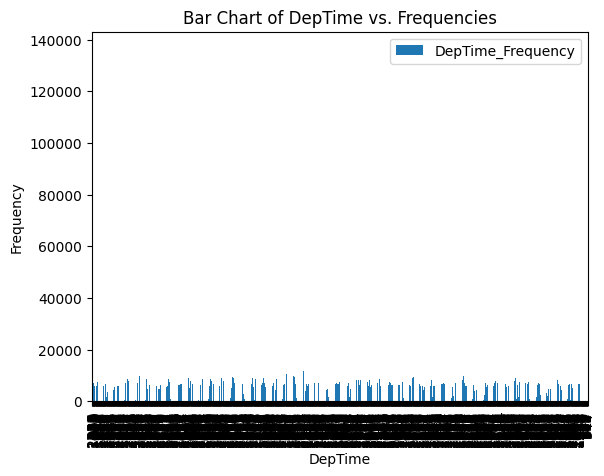

In [ ]:
# Create a bar chart
p_twoeight_deptime_df.plot(x='DepTime', y='DepTime_Frequency', kind='bar')

# Set labels and title
plt.xlabel("DepTime")
plt.ylabel("Frequency")
plt.title("Bar Chart of DepTime vs. Frequencies")

In [ ]:
twoeight_df_deptime.orderBy('DepTime_Frequency', ascending=False).show()

+-------+-----------------+
|DepTime|DepTime_Frequency|
+-------+-----------------+
|     NA|           136246|
|    555|            17227|
|    600|            16436|
|    700|            15169|
|    655|            15123|
|    557|            14686|
|    556|            14563|
|    558|            14071|
|    559|            12566|
|    658|            11849|
|    657|            11849|
|    656|            11834|
|    755|            11419|
|    825|            11305|
|    659|            11222|
|    630|            11190|
|    900|            11183|
|    855|            11066|
|   1700|            11006|
|   1655|            10736|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoeight_df_deptime.orderBy('DepTime_Frequency', ascending=True).show()

+-------+-----------------+
|DepTime|DepTime_Frequency|
+-------+-----------------+
|    347|                3|
|    346|                3|
|    417|                3|
|    338|                4|
|    342|                4|
|    344|                4|
|    429|                5|
|    336|                5|
|    420|                5|
|    302|                5|
|    421|                6|
|    341|                6|
|    353|                6|
|    312|                6|
|    422|                7|
|    425|                7|
|    349|                7|
|    348|                7|
|    416|                7|
|    357|                7|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoseven_df_Arrime = twoseven_df_times.groupby('ArrTime').\
agg(
    count('ArrTime').alias('ArrTime_Frequency'))
twoseven_df_Arrime.show()

+-------+-----------------+
|ArrTime|ArrTime_Frequency|
+-------+-----------------+
|   1436|             7305|
|   2136|             6511|
|   1159|             6965|
|    829|             5809|
|   1512|             6861|
|   2110|             7478|
|    853|             6163|
|    800|             6461|
|    944|             6696|
|    125|              734|
|    451|              295|
|   1746|             7438|
|   1808|             7789|
|    926|             7000|
|    919|             6682|
|   1241|             7560|
|   1903|             7079|
|   1528|             7191|
|   2034|             7576|
|   1953|             7434|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoseven_df_Arrime.count()

1441

In [ ]:
p_twoseven_arrtime_df = twoseven_df_Arrime.limit(2_000).toPandas()

Text(0.5, 1.0, 'Bar Chart of ArrTime vs. Frequencies')

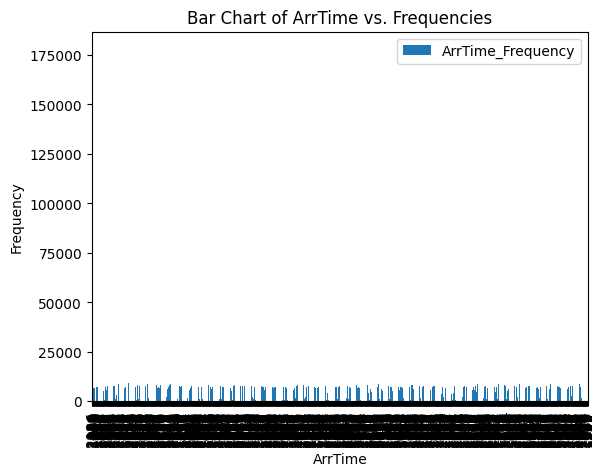

In [ ]:
# Create a bar chart
p_twoseven_arrtime_df.plot(x='ArrTime', y='ArrTime_Frequency', kind='bar')

# Set labels and title
plt.xlabel("ArrTime")
plt.ylabel("Frequency")
plt.title("Bar Chart of ArrTime vs. Frequencies")

In [ ]:
twoseven_df_Arrime.orderBy('ArrTime_Frequency', ascending=False).show()

+-------+-----------------+
|ArrTime|ArrTime_Frequency|
+-------+-----------------+
|     NA|           177927|
|   1230|             9145|
|   1630|             9105|
|   1620|             9072|
|   1030|             8959|
|   1625|             8953|
|   1020|             8947|
|   1025|             8936|
|   1225|             8892|
|   1015|             8862|
|   1610|             8838|
|   1830|             8827|
|   1800|             8817|
|   1615|             8804|
|   1400|             8758|
|   1820|             8757|
|   2030|             8731|
|   1235|             8701|
|   1810|             8698|
|   1815|             8693|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoseven_df_Arrime.orderBy('ArrTime_Frequency', ascending=True).show()

+-------+-----------------+
|ArrTime|ArrTime_Frequency|
+-------+-----------------+
|    409|               36|
|    357|               39|
|    404|               43|
|    356|               48|
|    358|               49|
|    413|               50|
|    402|               50|
|    408|               52|
|    359|               52|
|    331|               53|
|    348|               54|
|    349|               54|
|    354|               54|
|    334|               55|
|    416|               55|
|    406|               56|
|    342|               56|
|    400|               56|
|    333|               56|
|    346|               57|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoeight_df_Arrime = twoeight_df_times.groupby('ArrTime').\
agg(
    count('ArrTime').alias('ArrTime_Frequency'))
twoeight_df_Arrime.show()

+-------+-----------------+
|ArrTime|ArrTime_Frequency|
+-------+-----------------+
|   1512|             6568|
|   2136|             6178|
|    829|             5254|
|   1436|             6824|
|   1159|             6932|
|   2110|             6869|
|    800|             5859|
|    853|             5880|
|    944|             6101|
|    125|              529|
|    451|              278|
|    926|             6738|
|   1241|             7129|
|    919|             6471|
|   1808|             7449|
|   1746|             7285|
|   2034|             6928|
|   1528|             6919|
|      7|             2195|
|   1953|             6888|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoeight_df_Arrime.count()

1441

In [ ]:
p_twoeight_arrtime_df = twoeight_df_Arrime.limit(2_000).toPandas()

Text(0.5, 1.0, 'Bar Chart of ArrTime vs. Frequencies')

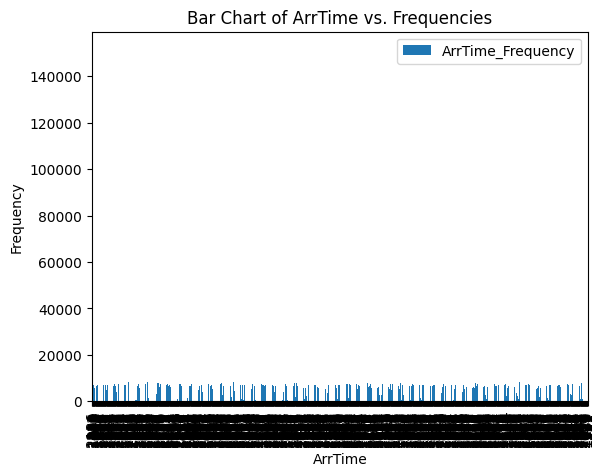

In [ ]:
# Create a bar chart
p_twoeight_arrtime_df.plot(x='ArrTime', y='ArrTime_Frequency', kind='bar')

# Set labels and title
plt.xlabel("ArrTime")
plt.ylabel("Frequency")
plt.title("Bar Chart of ArrTime vs. Frequencies")

In [ ]:
twoeight_df_Arrime.orderBy('ArrTime_Frequency', ascending=False).show()

+-------+-----------------+
|ArrTime|ArrTime_Frequency|
+-------+-----------------+
|     NA|           151649|
|   1020|             8435|
|   1400|             8365|
|   1015|             8289|
|   1410|             8286|
|   1610|             8254|
|   1405|             8228|
|   1010|             8206|
|   1025|             8184|
|   1210|             8177|
|   1800|             8173|
|   1810|             8172|
|   1620|             8165|
|   1215|             8160|
|   1625|             8147|
|   1615|             8121|
|   1220|             8111|
|   1600|             8108|
|   1630|             8104|
|   1540|             8066|
+-------+-----------------+
only showing top 20 rows



In [ ]:
twoeight_df_Arrime.orderBy('ArrTime_Frequency', ascending=True).show()

+-------+-----------------+
|ArrTime|ArrTime_Frequency|
+-------+-----------------+
|    416|               31|
|    411|               31|
|    414|               33|
|    356|               34|
|    352|               34|
|    401|               34|
|    359|               35|
|    358|               35|
|    346|               36|
|    405|               36|
|    343|               38|
|    408|               38|
|    354|               38|
|    347|               38|
|    407|               38|
|    334|               39|
|    419|               39|
|    341|               39|
|    402|               39|
|    345|               40|
+-------+-----------------+
only showing top 20 rows



In [ ]:
#As seen from the above bar and table graphs, we can conclude that the flights are not perfectly equally distributed throughout the day for both years 2007 and 2008.
#Every flight time has different frequencies:
# In 2007: most frequent DepTime is 6:00 and least frequent DepTime is 3:43.
#          most frequent ArrTime is 12:30 and least frequent ArrTime is 4:09.
# In 2008: most frequent DepTime is 5:55 and least frequent DepTime is tied at 3:47, 3:46, and 4:17.
#          most frequent ArrTime is 10:20 and least frequent ArrTime is tied at 4:16 and 4:11.



In [ ]:
#6. Do you see the worst delays at any certain times of the day?
#   Compare DepTime, ArrTime with CRSDepTime, CRSArrTime (scheduled arrival and departure time; CRS is the Computer Reservation System)
twoseven_df_times_del = twoseven_df.select("DepTime", "CRSDepTime", "DepDelay", "ArrTime", "CRSArrTime", "ArrDelay" )
twoseven_df_times_del.show()

+-------+----------+--------+-------+----------+--------+
|DepTime|CRSDepTime|DepDelay|ArrTime|CRSArrTime|ArrDelay|
+-------+----------+--------+-------+----------+--------+
|   1232|      1225|       7|   1341|      1340|       1|
|   1918|      1905|      13|   2043|      2035|       8|
|   2206|      2130|      36|   2334|      2300|      34|
|   1230|      1200|      30|   1356|      1330|      26|
|    831|       830|       1|    957|      1000|      -3|
|   1430|      1420|      10|   1553|      1550|       3|
|   1936|      1840|      56|   2217|      2130|      47|
|    944|       935|       9|   1223|      1225|      -2|
|   1537|      1450|      47|   1819|      1735|      44|
|   1318|      1315|       3|   1603|      1610|      -7|
|    836|       835|       1|   1119|      1130|     -11|
|   2047|      1955|      52|   2332|      2240|      52|
|   2128|      2035|      53|   2245|      2200|      45|
|    935|       940|      -5|   1048|      1105|     -17|
|   1251|     

In [ ]:
twoseven_df_dep_times_del = twoseven_df_times_del.groupby('CRSDepTime').\
agg(
    avg('DepDelay').alias('DepDelayAvg'))
twoseven_df_dep_times_del.show()

+----------+------------------+
|CRSDepTime|       DepDelayAvg|
+----------+------------------+
|      1645|16.518500317974215|
|      1959|18.323384831460675|
|      1342|13.344600938967137|
|      1829|16.070300560366785|
|      1238|  9.66597510373444|
|      2142|10.137724550898204|
|      2122|10.401004304160688|
|       833|  4.52280701754386|
|      1025| 6.669610007358352|
|       540|3.9672824393501003|
|      1507|12.695116168800379|
|      1522|12.744431418522861|
|       858| 4.918918918918919|
|      1127| 8.503566333808845|
|      1721|17.871699669966997|
|      2235|10.782401902497027|
|       737| 7.084860173577628|
|       623|  3.58974358974359|
|      1650| 17.89566218073714|
|      1322|15.145687645687646|
+----------+------------------+
only showing top 20 rows



In [ ]:
twoseven_df_dep_times_del.orderBy('DepDelayAvg', ascending=False).show()

+----------+------------------+
|CRSDepTime|       DepDelayAvg|
+----------+------------------+
|        57|             243.0|
|       420|             107.0|
|        58|55.857142857142854|
|        52|48.333333333333336|
|       105| 33.63636363636363|
|      2216|33.166666666666664|
|       305|31.774193548387096|
|      2321|29.636363636363637|
|      2007|28.628895184135978|
|       210|              28.5|
|      2332| 28.05263157894737|
|      2208|             27.68|
|         1|27.333333333333332|
|       146|26.178571428571427|
|      2211| 25.84864864864865|
|       410|25.708333333333332|
|      2006|25.625250501002004|
|      1956|25.556435643564356|
|      2003|24.746745562130176|
|      1827| 24.51422963689892|
+----------+------------------+
only showing top 20 rows



In [ ]:
twoseven_df_dep_times_del.orderBy('DepDelayAvg', ascending=True).show()

+----------+-------------------+
|CRSDepTime|        DepDelayAvg|
+----------+-------------------+
|         0|               NULL|
|       315|              -16.4|
|       548|              -10.0|
|       534| -7.478260869565218|
|        29|               -7.0|
|         2|               -7.0|
|        54|               -7.0|
|       255|               -5.0|
|       539|-4.1063829787234045|
|      2301|               -4.0|
|       455|               -4.0|
|       159|               -3.5|
|       541|  -3.36734693877551|
|       546|-3.2475247524752477|
|       518| -3.165289256198347|
|       523|-2.4477611940298507|
|       512| -2.390909090909091|
|       553|-2.1184210526315788|
|       547|-1.9508196721311475|
|       450|-1.8487394957983194|
+----------+-------------------+
only showing top 20 rows



In [ ]:
twoseven_df_dep_times_del.count()

1188

In [ ]:
p_twoseven_df_dep_times_del = twoseven_df_dep_times_del.limit(2_000).toPandas()

Text(0.5, 1.0, 'Bar Chart of DepDelayAvg by CRSDepTime')

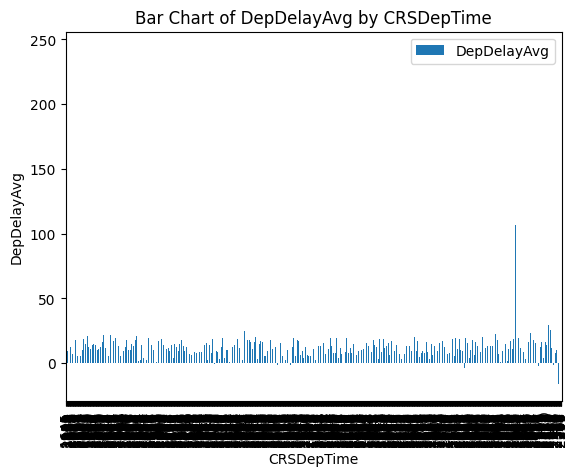

In [ ]:
# Create a bar chart
p_twoseven_df_dep_times_del.plot(x='CRSDepTime', y='DepDelayAvg', kind='bar')

# Set labels and title
plt.xlabel("CRSDepTime")
plt.ylabel("DepDelayAvg")
plt.title("Bar Chart of DepDelayAvg by CRSDepTime")

In [ ]:
twoeight_df_times_del = twoeight_df.select("DepTime", "CRSDepTime", "DepDelay", "ArrTime", "CRSArrTime", "ArrDelay" )
twoeight_df_times_del.show()

+-------+----------+--------+-------+----------+--------+
|DepTime|CRSDepTime|DepDelay|ArrTime|CRSArrTime|ArrDelay|
+-------+----------+--------+-------+----------+--------+
|   2003|      1955|       8|   2211|      2225|     -14|
|    754|       735|      19|   1002|      1000|       2|
|    628|       620|       8|    804|       750|      14|
|    926|       930|      -4|   1054|      1100|      -6|
|   1829|      1755|      34|   1959|      1925|      34|
|   1940|      1915|      25|   2121|      2110|      11|
|   1937|      1830|      67|   2037|      1940|      57|
|   1039|      1040|      -1|   1132|      1150|     -18|
|    617|       615|       2|    652|       650|       2|
|   1620|      1620|       0|   1639|      1655|     -16|
|    706|       700|       6|    916|       915|       1|
|   1644|      1510|      94|   1845|      1725|      80|
|   1426|      1430|      -4|   1426|      1425|       1|
|    715|       715|       0|    720|       710|      10|
|   1702|     

In [ ]:
twoeight_df_dep_times_del = twoeight_df_times_del.groupby('CRSDepTime').\
agg(
    avg('DepDelay').alias('DepDelayAvg'))
twoeight_df_dep_times_del.show()

+----------+------------------+
|CRSDepTime|       DepDelayAvg|
+----------+------------------+
|      1645|15.458133530062707|
|      1959|15.945091945091946|
|      1829|13.551972846839202|
|      1238|10.190964136003727|
|      1342|12.814651368049427|
|      2122|11.505263157894737|
|      2142|12.377358490566039|
|       833| 3.932912391475927|
|       148|             169.5|
|      1025| 6.408775891605669|
|      2235|  9.41090146750524|
|      1522|12.953582694907617|
|       623| 2.480628272251309|
|       540|2.5446475195822456|
|       858| 4.618814573137575|
|      1127|  8.68014484007242|
|      1721|19.248728094968907|
|      1507|10.290614578370652|
|       737|3.1987261146496815|
|      1650|16.169166757910872|
+----------+------------------+
only showing top 20 rows



In [ ]:
twoeight_df_dep_times_del.orderBy('DepDelayAvg', ascending=False).show()

+----------+------------------+
|CRSDepTime|       DepDelayAvg|
+----------+------------------+
|       310|             976.0|
|       148|             169.5|
|       227|              83.0|
|      2326|              69.8|
|      2336| 68.14285714285714|
|       120|           61.3125|
|       231|              59.0|
|       352|              58.0|
|      2321|              47.6|
|       250|              45.0|
|       151|              44.0|
|        14|              39.0|
|      2357| 37.41463414634146|
|      2331| 35.30434782608695|
|        17|33.166666666666664|
|       140|              33.0|
|      2334|31.962962962962962|
|      2324|28.661290322580644|
|      2203|27.858695652173914|
|      2156|26.258845437616387|
+----------+------------------+
only showing top 20 rows



In [ ]:
twoeight_df_dep_times_del.orderBy('DepDelayAvg', ascending=True).show()

+----------+-------------------+
|CRSDepTime|        DepDelayAvg|
+----------+-------------------+
|       149|               NULL|
|       350|               NULL|
|       516|               -8.0|
|       514| -7.688888888888889|
|       355|               -7.0|
|       504|             -6.375|
|       220|               -6.0|
|       135| -5.481481481481482|
|       517| -4.918918918918919|
|       518| -4.885714285714286|
|       547| -4.728155339805825|
|       522| -4.671052631578948|
|       512| -3.983050847457627|
|       225| -3.789473684210526|
|       539|-3.6835443037974684|
|       526|-3.5185185185185186|
|       521|-3.3680555555555554|
|      2253|  -3.10455764075067|
|       548|               -3.0|
|        53|               -3.0|
+----------+-------------------+
only showing top 20 rows



In [ ]:
twoeight_df_dep_times_del.count()

1217

In [ ]:
p_twoeight_df_dep_times_del = twoeight_df_dep_times_del.limit(2_000).toPandas()

Text(0.5, 1.0, 'Bar Chart of DepDelayAvg by CRSDepTime')

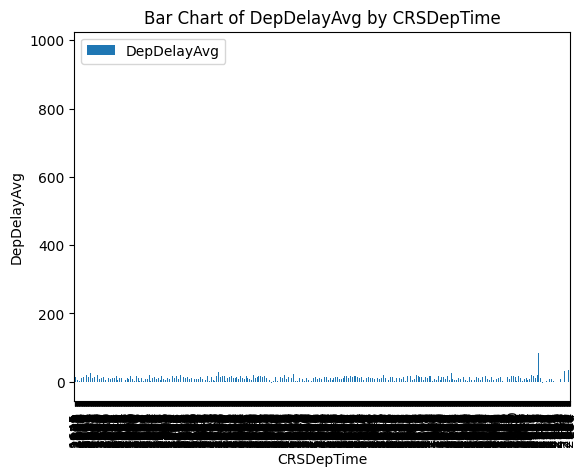

In [ ]:
# Create a bar chart
p_twoeight_df_dep_times_del.plot(x='CRSDepTime', y='DepDelayAvg', kind='bar')

# Set labels and title
plt.xlabel("CRSDepTime")
plt.ylabel("DepDelayAvg")
plt.title("Bar Chart of DepDelayAvg by CRSDepTime")

In [ ]:
twoseven_df_arr_times_del = twoseven_df_times_del.groupby('CRSArrTime').\
agg(
    avg('ArrDelay').alias('ArrDelayAvg'))
twoseven_df_arr_times_del.show()

+----------+-------------------+
|CRSArrTime|        ArrDelayAvg|
+----------+-------------------+
|      1645| 13.585128017938155|
|      2142|  16.50584307178631|
|      1342|   8.63849765258216|
|       833| 1.3214609115605191|
|      1959| 18.181597222222223|
|      2122|  17.39958714243586|
|      1238|  6.436788378484492|
|      1829| 19.927321826934367|
|       148|                6.6|
|      2235|  17.75985272057821|
|      1025|  3.556086603259571|
|       737|0.34909264565425024|
|      1127|  3.755015839493136|
|      1507|  8.420525059665872|
|      1522|    9.3915770609319|
|       858| 2.2324019344438475|
|      1721| 13.420672409002501|
|       540| 6.1240045506257115|
|       623|   6.92806484295846|
|      1650| 15.246485224680354|
+----------+-------------------+
only showing top 20 rows



In [ ]:
twoseven_df_arr_times_del.orderBy('ArrDelayAvg', ascending=False).show()

+----------+------------------+
|CRSArrTime|       ArrDelayAvg|
+----------+------------------+
|       318|              94.0|
|       326| 80.66666666666667|
|       259|              71.0|
|       351|              62.0|
|       345|              55.0|
|       152|              39.0|
|       321| 33.35294117647059|
|       332|29.869565217391305|
|       145|28.747474747474747|
|       400|            28.325|
|       207|              27.6|
|       209|26.647058823529413|
|       106|             25.48|
|       158|24.859154929577464|
|       303|24.724137931034484|
|       211|              24.5|
|        56|23.678466076696164|
|         6|23.598146588037068|
|         4|  22.4735516372796|
|      1913|22.470636889991727|
+----------+------------------+
only showing top 20 rows



In [ ]:
twoseven_df_arr_times_del.orderBy('ArrDelayAvg', ascending=True).show()

+----------+-------------------+
|CRSArrTime|        ArrDelayAvg|
+----------+-------------------+
|       353|               NULL|
|      2400|               NULL|
|         0|               NULL|
|       417|               NULL|
|       235|              -23.0|
|       407|              -23.0|
|       403|              -22.0|
|       214|              -16.0|
|       446|-14.824324324324325|
|       411|            -14.375|
|       449|-14.333333333333334|
|       243|  -9.30232558139535|
|       453|              -9.24|
|       430| -9.148148148148149|
|       541| -8.560975609756097|
|       406|               -7.0|
|       631| -6.172069825436409|
|       434| -5.866666666666666|
|       201| -5.612903225806452|
|       141|               -5.4|
+----------+-------------------+
only showing top 20 rows



In [ ]:
twoseven_df_arr_times_del.count()

1398

In [ ]:
p_twoseven_df_arr_times_del = twoseven_df_arr_times_del.limit(2_000).toPandas()

Text(0.5, 1.0, 'Bar Chart of ArrDelayAvg by CRSArrTime')

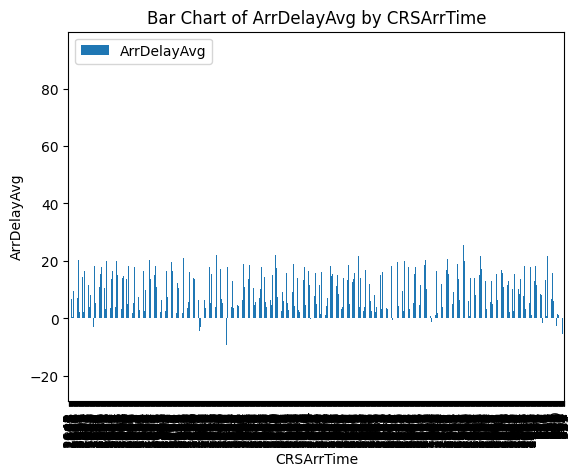

In [253]:
# Create a bar chart
p_twoseven_df_arr_times_del.plot(x='CRSArrTime', y='ArrDelayAvg', kind='bar')

# Set labels and title
plt.xlabel("CRSArrTime")
plt.ylabel("ArrDelayAvg")
plt.title("Bar Chart of ArrDelayAvg by CRSArrTime")

In [254]:
twoeight_df_arr_times_del = twoeight_df_times_del.groupby('CRSArrTime').\
agg(
    avg('ArrDelay').alias('ArrDelayAvg'))
twoeight_df_arr_times_del.show()

+----------+-------------------+
|CRSArrTime|        ArrDelayAvg|
+----------+-------------------+
|      1645|  9.875013035770154|
|      2142| 15.843181818181819|
|      1342|  7.977380952380952|
|      2122| 12.829296424452133|
|      1829| 15.903433162892622|
|       833| 0.6608187134502924|
|      1959| 16.503421490660255|
|      1238|  6.121393460141055|
|       148| 12.860759493670885|
|      2235| 13.388091772371249|
|      1025|  2.207188160676533|
|       858|  4.265901981230448|
|      1507|  7.878755074424898|
|      1127|  3.896636587366694|
|       737|0.48172757475083056|
|      1721| 11.717948717948717|
|      1522|  8.974006116207951|
|       623| 1.8975356679636834|
|       540|  2.669761273209549|
|      1650|  10.07308732710662|
+----------+-------------------+
only showing top 20 rows



In [255]:
twoeight_df_arr_times_del.orderBy('ArrDelayAvg', ascending=False).show()

+----------+------------------+
|CRSArrTime|       ArrDelayAvg|
+----------+------------------+
|       151|             227.0|
|       402|             195.0|
|       411|              68.0|
|       410|              58.0|
|       200|              57.0|
|       209|              36.5|
|       257|              35.0|
|       429|             30.68|
|       141|30.428571428571427|
|       436|             29.75|
|       157|28.341463414634145|
|       350|              27.0|
|       341|           26.4625|
|        42|23.581632653061224|
|       103|23.359477124183005|
|      1929| 23.16261042004687|
|       146| 22.69607843137255|
|        38|21.672463768115943|
|       507| 20.24468085106383|
|       440|19.857142857142858|
+----------+------------------+
only showing top 20 rows



In [256]:
twoeight_df_arr_times_del.orderBy('ArrDelayAvg', ascending=True).show()

+----------+-------------------+
|CRSArrTime|        ArrDelayAvg|
+----------+-------------------+
|      2400|               NULL|
|       145|               NULL|
|       238|               NULL|
|       245|               NULL|
|       400|               NULL|
|       321|-20.046511627906977|
|       150|              -17.0|
|       206|              -17.0|
|       417|             -16.75|
|       230|              -15.0|
|       442|-14.214285714285714|
|       342|              -14.0|
|       204|              -14.0|
|       120|-13.285714285714286|
|       324|              -12.6|
|       408|              -12.0|
|       347|-11.454545454545455|
|       114|-11.102189781021897|
|       229|              -10.2|
|       437|  -9.82258064516129|
+----------+-------------------+
only showing top 20 rows



In [257]:
twoeight_df_arr_times_del.count()

1378

In [258]:
p_twoeight_df_arr_times_del = twoeight_df_arr_times_del.limit(2_000).toPandas()

Text(0.5, 1.0, 'Bar Chart of ArrDelayAvg by CRSArrTime')

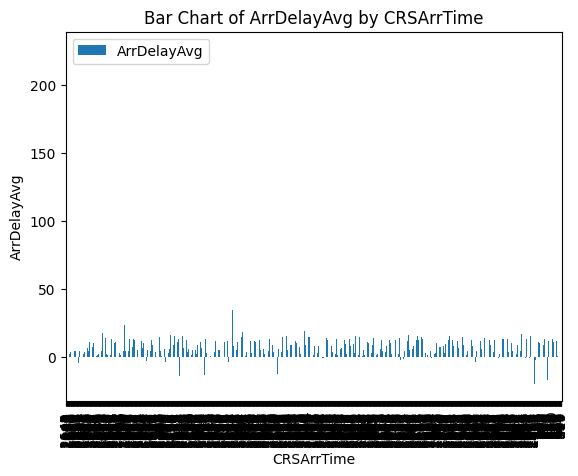

In [259]:
# Create a bar chart
p_twoeight_df_arr_times_del.plot(x='CRSArrTime', y='ArrDelayAvg', kind='bar')

# Set labels and title
plt.xlabel("CRSArrTime")
plt.ylabel("ArrDelayAvg")
plt.title("Bar Chart of ArrDelayAvg by CRSArrTime")

In [ ]:
# In conclusion, there are certain time of the day that has worst delays on average.
# In 2007: The worst DepDelay is at 5:7 and the least DepDelay is at 3:15.
#          The worst ArrDelay is at 3:18 and the least ArrDelay is tied at 2:35 and 4:07.
# In 2008: The worst DepDelay is at 3:10 and the least DepDelay is at 5:16.
#          The worst ArrDelay is at 1:51 and the least ArrDelay is at 3:21.


In [ ]:
#Your final output should look like a chart (i.e. bar chart, line chart, etc.), the chart can also be supplemented by a table as needed.
